## Extracting the DEM Features

In [1]:
# !ls ../../data_0718/USGS_3DEP_0722_3000m

In [18]:
# !ls ../../data_0718/USGS_3DEP_1m/

In [1]:
import os
import glob 
import json
import numpy as np 
from scipy.stats import iqr
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

Visualize a sample DEM

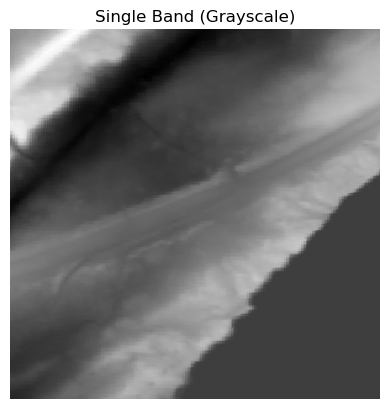

In [ ]:
tif_path = '../../data_0718/USGS_3DEP_0722_3000m/12722_USGS_3DEP_2024.tif'
# tif_path = '../../data_0718/USGS_3DEP_1m/4358_USGS_3DEP_1m.tif'

with rasterio.open(tif_path) as src:
    img = src.read()
    img = center_crop(img, crop_size=300)
    plt.imshow(img[0], cmap='gray')
    plt.title('Single Band (Grayscale)')
    plt.axis('off')
    plt.show()

In [2]:
def center_crop(img, crop_size=300):
    """
    Center crop a square patch from a (C, H, W) image.
    
    Parameters:
        img (np.ndarray): Input image of shape (1, H, W)
        crop_size (int): Size of the crop (default 300)
        
    Returns:
        np.ndarray: Cropped image of shape (1, crop_size, crop_size)
    """
    _, h, w = img.shape
    ch = (h - crop_size) // 2
    cw = (w - crop_size) // 2
    return img[:, ch:ch+crop_size, cw:cw+crop_size]

def extract_valid_files(json_path, feature_path):
    with open(json_path) as f: 
        features_json = json.load(f)
    
    valid_ids = [ # filter out scene without S1
        str(item['id'])
        for item in features_json
        if item.get('Sentinel_1') not in [None, 'None']
    ]

    tif_files = glob.glob(os.path.join(feature_path, '*.tif'))
    valid_tif_files = [
        f for f in tif_files
        if os.path.basename(f).split('_')[0] in sorted(valid_ids)
    ]
    return valid_tif_files


def compute_stats(tif_path, crop=False): 
    with rasterio.open(tif_path) as src:
        band = src.read().astype(np.float32)
        crs = src.crs.to_string()

        # Mask no-data values if available
        if src.nodata is not None:
            band = np.ma.masked_equal(band, src.nodata)
        
        if crop: 
            center_crop(band, crop_size=300)
        # Flatten and remove masked values for stats
        band_flat = band.compressed() if np.ma.isMaskedArray(band) else band.flatten()
        band_min = np.min(band_flat)
        band_max = np.max(band_flat)
        band_mean = np.mean(band_flat)
        band_iqr = iqr(band_flat)
    return crs, band_min, band_max, band_mean, band_iqr 

##### 10 m DEM Extraction

In [5]:
json_path = "../../data_0718/json/flooding_dataset_with_precipitation_0801_with_height_above.json"
feature_path = '../../data_0718/USGS_3DEP_0722_3000m/' 
output_csv = "./data/dem_features.csv"

tif_files = extract_valid_files(json_path, feature_path)

stats_list = []
for tif_path in tif_files:
    try: 
        file_id = os.path.basename(tif_path).split('_')[0]
        year = os.path.basename(tif_path).split('_')[-1]
        crs, band_min, band_max, band_mean, band_iqr  = compute_stats(tif_path)
        band_stats = {
                        'file_id': file_id,
                        'year': year,
                        'dem_min': band_min,
                        'dem_max': band_max,
                        'dem_mean': band_mean,
                        'dem_iqr': band_iqr,
                        "projection": crs
                    }
        stats_list.append(band_stats)
    except Exception as e:
        print(f"Error processing {file_id}: {e}")

df = pd.DataFrame(stats_list)
df.to_csv(output_csv, index=False)
print(f"Feature statistics saved to: {output_csv}")

Feature statistics saved to: ./data/dem_features.csv


##### 1m DEM Extraction

In [3]:
json_path = "../../data_0718/json/flooding_dataset_with_precipitation_0801_with_height_above.json"
feature_path = '../../data_0718/USGS_3DEP_1m/' 
output_csv = "./data/dem_1m_features.csv"

tif_files = extract_valid_files(json_path, feature_path)

stats_list = []
for tif_path in tif_files:
    try: 
        file_id = os.path.basename(tif_path).split('_')[0]
        year = os.path.basename(tif_path).split('_')[-1]
        crs, band_min, band_max, band_mean, band_iqr  = compute_stats(tif_path, crop=True)
        band_stats = {
                        'file_id': file_id,
                        'year': year,
                        'dem_min': band_min,
                        'dem_max': band_max,
                        'dem_mean': band_mean,
                        'dem_iqr': band_iqr,
                        "projection": crs
                    }
        stats_list.append(band_stats)
    except Exception as e:
        print(f"Error processing {file_id}: {e}")

df = pd.DataFrame(stats_list)
df.to_csv(output_csv, index=False)
print(f"Feature statistics saved to: {output_csv}")

Feature statistics saved to: ./data/dem_1m_features.csv
